## Trabajo Practico 5

#### Materia: Vision por Computadora 1
#### Alumno: Lucas Rivela

In [2]:
import cv2 as cv
import imutils
import math
import matplotlib.pyplot as plt
import numpy as np
import random

#### Parte 1 - Pruebo el método para un frame

In [3]:
# Abrimos el archivo
filename = 'slow_traffic_small.mp4'
capture = cv.VideoCapture(filename)

In [3]:
ret, frame = capture.read()

In [4]:
frame.shape
frame = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
frame.shape

(360, 640, 3)

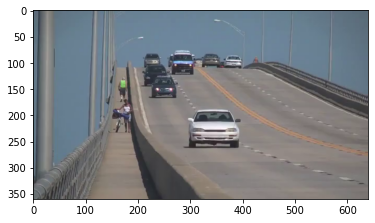

In [5]:
plt.imshow(frame)

In [6]:
length = int(capture.get(cv.CAP_PROP_FRAME_COUNT))
length

914

In [7]:
FRAMES_NUM = 25
sampl = np.random.randint(low=1, high=914, size=(FRAMES_NUM,))
sampl.shape

(25,)

In [8]:
lista_frames = []
for s in sampl:
    capture.set(1, s)
    ret, frame = capture.read()
    frame = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
    lista_frames.append(frame)

In [9]:
tensor = np.array(lista_frames)
tensor.shape

(25, 360, 640, 3)

In [10]:
media = np.median(tensor, axis=0)
media.shape

(360, 640, 3)

In [11]:
media = cv.normalize(media, media, 0, 255, cv.NORM_MINMAX).astype('uint8')

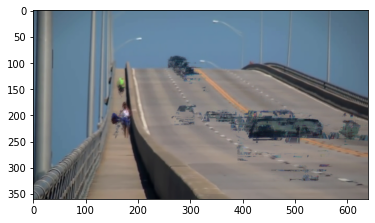

In [12]:
plt.imshow(media)

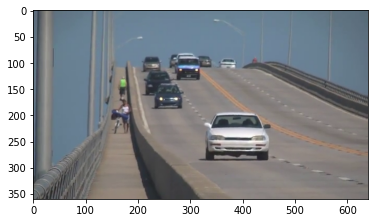

In [31]:
capture.set(1, 50)
ret, frame_actual = capture.read()
frame_actual = cv.cvtColor(frame_actual, cv.COLOR_BGR2RGB)
plt.imshow(frame_actual)

In [32]:
media = cv.GaussianBlur(media, (3, 3), 0)
frame_actual = cv.GaussianBlur(frame_actual, (3, 3), 0)

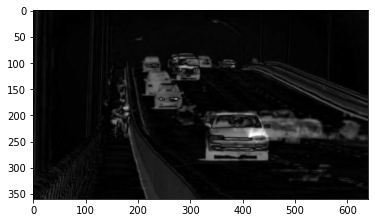

In [33]:
grayMedianFrame = cv.cvtColor(media, cv.COLOR_BGR2GRAY)
grayFrameActual = cv.cvtColor(frame_actual, cv.COLOR_BGR2GRAY)

dframe = cv.absdiff(grayFrameActual, grayMedianFrame)
plt.imshow(dframe, cmap='gray')

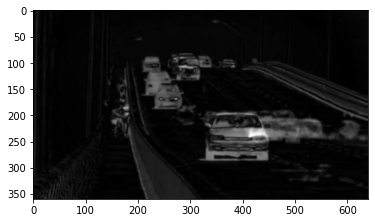

In [34]:
dframe = cv.GaussianBlur(dframe, (3, 3), 0)
#dframe = cv.medianBlur(dframe, 11, dframe)
plt.imshow(dframe, cmap='gray')

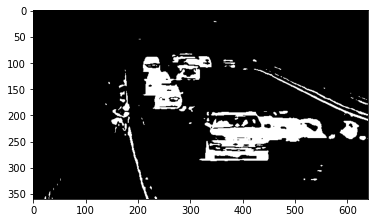

In [35]:
th, dframe = cv.threshold(dframe, 30, 255, cv.THRESH_BINARY | cv.THRESH_OTSU)
plt.imshow(dframe, cmap='gray')

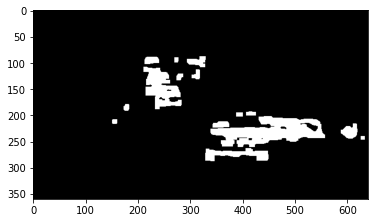

In [36]:
# Creamos un elemento estructurante y aplicamos operaciones morfologicas
kernel1 = np.ones((3,3),np.uint8)
opening = cv.morphologyEx(dframe, cv.MORPH_OPEN, kernel1, iterations = 3)
plt.imshow(opening, cmap='gray')

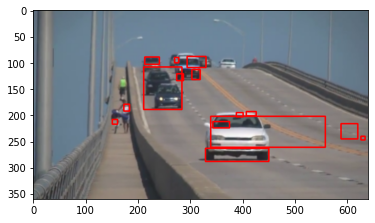

In [37]:
cnts, _ = cv.findContours(opening.copy(), cv.RETR_EXTERNAL,cv.CHAIN_APPROX_SIMPLE)
for cnt in cnts:
    x,y,w,h = cv.boundingRect(cnt)
    frame_actual = cv.rectangle(frame_actual,(x,y),(x+w,y+h),(255,0,0),2)

plt.imshow(frame_actual)

#### Parte 2 - Extrapolo a video

In [2]:
# Abrimos el archivo
FILENAME = 'slow_traffic_small.mp4'
N_FRAMES = 25
REFRESH_INTERVAL = 5

In [3]:
def get_n_frames(capture, n_frames):
    frames = []
    frameIds = np.random.randint(low=1, high=capture.get(cv.CAP_PROP_FRAME_COUNT), size=(n_frames,))
    for fid in frameIds:
        capture.set(cv.CAP_PROP_POS_FRAMES, fid)
        ret, frame = capture.read()
        frames.append(frame)

    return frames

In [4]:
def naive_background_substraction(filename, n_frames=25, refresh_interval=3):
    capture = cv.VideoCapture(filename)
    fps = math.ceil(capture.get(cv.CAP_PROP_FPS))
    
    every_n_frames = refresh_interval * fps

    #frameIds = capture.get(cv.CAP_PROP_FRAME_COUNT) * np.random.uniform(size=n_frames)
    frameIds = np.random.randint(low=1, high=100, size=(n_frames,))

    # Store selected frames in an array
    frames = []
    for fid in frameIds:
        capture.set(cv.CAP_PROP_POS_FRAMES, fid)
        ret, frame = capture.read()
        frames.append(frame)

    # Calculate the median along the time axis
    medianFrame = np.median(np.array(frames), axis=0).astype(dtype=np.uint8)
    medianFrame = cv.normalize(medianFrame, medianFrame, 0, 255, cv.NORM_MINMAX).astype('uint8')
    medianFrame = cv.GaussianBlur(medianFrame, (3, 3), 0)

    # Reset frame number to 0
    capture.set(cv.CAP_PROP_POS_FRAMES, 0)

    # Convert background to grayscale
    grayMedianFrame = cv.cvtColor(medianFrame, cv.COLOR_BGR2GRAY)

    # Loop over all frames
    ret = True
    frame_counter = 0
    #total_cycles = 0
    past_frames = []
    while(ret):
        # Read frame
        ret, frame_rgb = capture.read()
        
        if not ret:
            break
        
        #total_cycles += 1
        past_frames.append(frame_rgb)
        frame_rgb = cv.GaussianBlur(frame_rgb, (3, 3), 0)

        if frame_counter == every_n_frames:
            #frames = get_n_frames(capture, n_frames)
            # Calculate the median along the time axis
            medianFrame = np.median(np.array(past_frames), axis=0).astype(dtype=np.uint8)
            medianFrame = cv.normalize(medianFrame, medianFrame, 0, 255, cv.NORM_MINMAX).astype('uint8')
            grayMedianFrame = cv.cvtColor(medianFrame, cv.COLOR_BGR2GRAY)

            #capture.set(cv.CAP_PROP_POS_FRAMES, total_cycles)

            frame_counter = 0

        else:
            frame_counter += 1

         # Convert current frame to grayscale
        frame = cv.cvtColor(frame_rgb, cv.COLOR_BGR2GRAY)
        # Calculate absolute difference of current frame and the median frame
        dframe = cv.absdiff(frame, grayMedianFrame)
        dframe = cv.GaussianBlur(dframe, (3, 3), 0)

        # Treshold to binarize
        th, dframe = cv.threshold(dframe, 30, 255, cv.THRESH_BINARY | cv.THRESH_OTSU)

        kernel = np.ones((3,3),np.uint8)
        opening = cv.morphologyEx(dframe, cv.MORPH_OPEN, kernel, iterations = 3)

        cnts, _ = cv.findContours(opening, cv.RETR_EXTERNAL,cv.CHAIN_APPROX_SIMPLE)

        for cnt in cnts:
            x,y,w,h = cv.boundingRect(cnt)
            frame_rgb = cv.rectangle(frame_rgb,(x,y),(x+w,y+h),(255,0,0),2)
        
        

        # Display image
        cv.imshow('frame', frame_rgb)
        cv.waitKey(20)

    # Release video object
    capture.release()

    # Destroy all windows
    cv.destroyAllWindows()

In [5]:
naive_background_substraction(FILENAME)

: 

#### Parte 3 - Comparación con otros métodos

In [4]:
backSub = cv.createBackgroundSubtractorMOG2()
capture = cv.VideoCapture(filename)

# Corremos la sustraccion
while True:
    # Leemos un frame
    ret, frame = capture.read()
    if frame is None:
        break
    
    # Aplicamos la sustracción al frame leído
    # Cada frame se utiliza tanto para calcular la máscara de primer plano como para actualizar el fondo.
    # Si se desea cambiar la tasa de aprendizaje utilizada para actualizar el modelo de fondo, es posible
    # establecer una tasa de aprendizaje específica pasando un parámetro al método apply.
    fgMask = backSub.apply(frame)
    
    # Escribimos sobre la imagen el número de frame procesado
    cv.rectangle(frame, (10, 2), (100,20), (255,255,255), -1)
    cv.putText(frame, str(capture.get(cv.CAP_PROP_POS_FRAMES)), (15, 15), cv.FONT_HERSHEY_SIMPLEX, 0.5 , (0,0,0))
    
    # mostramos frame original e imagen binaria background/foreground
    cv.imshow('Frame', frame)
    cv.imshow('FG Mask', fgMask)
    
    # Corresmos hasta que termine o apriete escape
    cv.waitKey(30)

cv.destroyAllWindows()
capture.release()

: 

#### Conclusiones

